<h1> Predizione dei prezzi delle auto </h1>

**Author**: Simone Festa, University of Rome, Tor Vergata

**Subject**: Machine Learning, y. 2023/2024

<h2> Introduzione</h2>

L’obiettivo del progetto è addestrare e valutare uno o più modelli di regressione per predire il
 prezzo di vendita di automobili usate.
 Il progetto si basa su un dataset contenente circa 40,000 esempi di automobili usate vendute
 nel Regno Unito, fornito tramite il file CSV `car_prices.csv`

 | Colonna        | Descrizione                                     |
|----------------|-------------------------------------------------|
| manufacturer   | Casa produttrice                                |
| model          | Modello                                         |
| year           | Anno di produzione                              |
| transmission   | Cambio automatico/manuale                       |
| mileage        | Miglia percorse                                 |
| fuelType       | Alimentazione (e.g., benzina, diesel)           |
| mpg            | Consumo stimato (miglia per gallone)            |
| engineSize     | Cilindrata                                      |
| price          | Prezzo di vendita (target della predizione)     |

<h3> Imports </h3>

In [32]:
# Import delle librerie per il data handling e la visualizzazione
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

# Import delle librerie per il preprocessing e la modellazione
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

# Import dei modelli di regressione
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor

# Import delle librerie per le reti neurali
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanAbsoluteError
from keras.optimizers import Adam

# Import di Keras Tuner per l'ottimizzazione iperparametrica
import keras_tuner as kt
from keras_tuner import Hyperband


In [33]:
path ='car_prices.csv'
dataset = pd.read_csv(path)
dataset.head()

,manufacturer,model,year,transmission,mileage,fuelType,mpg,engineSize,price
0,Audi,A1,2017,Manual,15735,Petrol,55.4,1.4,12500
1,Audi,A6,2016,Automatic,36203,Diesel,64.2,2.0,16500
2,Audi,A1,2016,Manual,29946,Petrol,55.4,1.4,11000
3,Audi,A4,2017,Automatic,25952,Diesel,67.3,2.0,16800
4,Audi,A3,2019,Manual,1998,Petrol,49.6,1.0,17300


In [34]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41306 entries, 0 to 41305
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   manufacturer  41306 non-null  object 
 1   model         41306 non-null  object 
 2   year          41306 non-null  int64  
 3   transmission  41306 non-null  object 
 4   mileage       41306 non-null  int64  
 5   fuelType      41306 non-null  object 
 6   mpg           41306 non-null  float64
 7   engineSize    41306 non-null  float64
 8   price         41306 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 2.8+ MB


<h2> Visualizzazione dati</h2>

<h3> Distribuzione delle variabili numeriche</h3>

In [35]:
# Elenco delle variabili numeriche da visualizzare
numerical_features = ['year', 'mileage', 'mpg', 'engineSize']

<h4>Distribuzione delle variabili numeriche rapportate al numero di auto</h4>

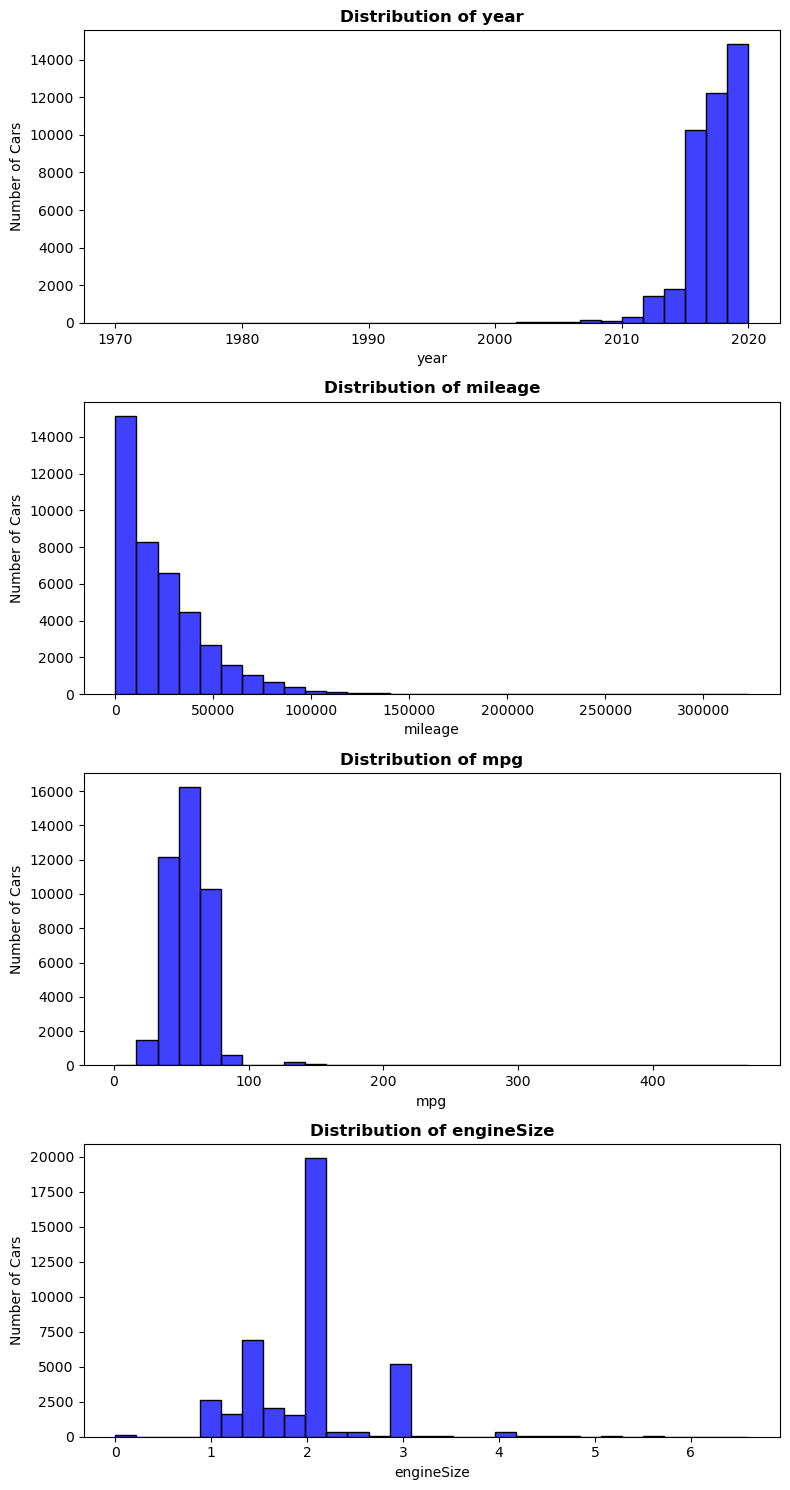

In [36]:
#Istogramma
fig, axes = plt.subplots(len(numerical_features), 1, figsize=(8, 15), sharex=False)

for i, feature in enumerate(numerical_features):
    sns.histplot(data=dataset, x=feature, kde=False, bins=30, ax=axes[i], color='blue', edgecolor='black')
    axes[i].set_title(f'Distribution of {feature}',fontweight='bold')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Number of Cars')

plt.tight_layout()
plt.show()

<h5> Osservazioni </h5>
Dai grafici risultanti, è evidente che nel dataset le auto tendono a essere più recenti e con un numero di chilometri relativamente basso. La distribuzione dei consumi (miglia per gallone) appare più equa, suggerendo una varietà di modelli con differenti efficienze. Per quanto riguarda la cilindrata, la maggior parte delle auto ha una cilindrata di circa 2 litri, indicando una prevalenza di motori di dimensioni medie.

<h4> Distribuzione delle variabili numeriche rapportate al prezzo </h4>

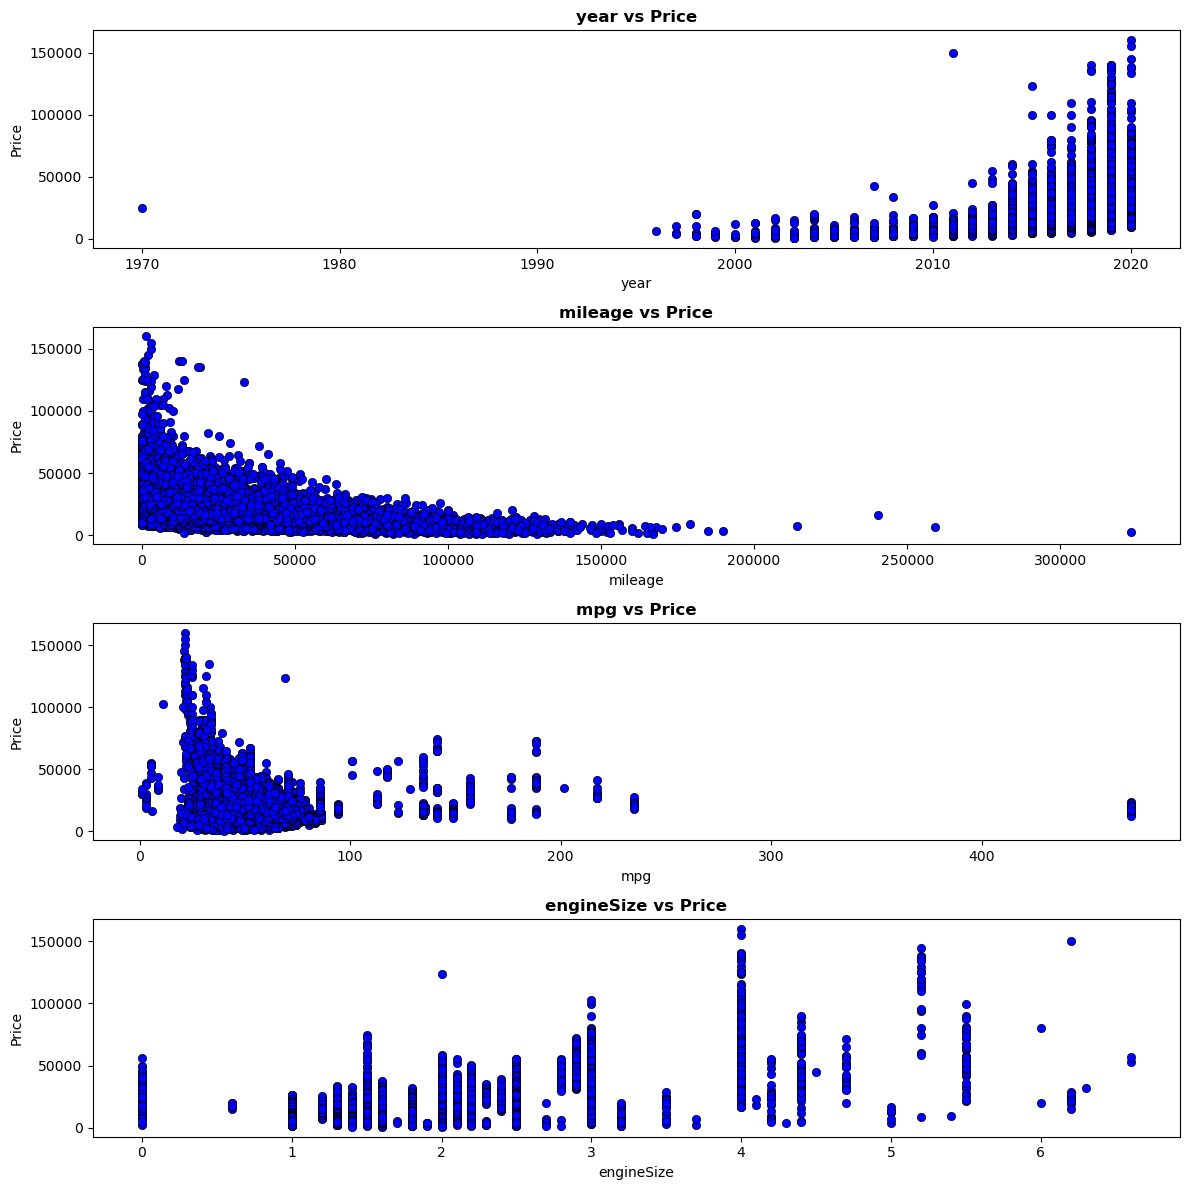

In [37]:
fig, axes = plt.subplots(len(numerical_features), 1, figsize=(12, 10), sharex=False)

for i, feature in enumerate(numerical_features):
    sns.scatterplot(x=dataset[feature], y=dataset['price'], ax=axes[i], color='blue', edgecolor='black')
    axes[i].set_title(f'{feature} vs Price',fontweight='bold')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Price')

plt.tight_layout()
plt.show()

<h5> Osservazioni </h5>

È possibile notare come le varie distribuzioni presentino forme asimmetriche.

1. **Relazione Anno e Prezzo**:
   - È possibile notare una *dipendenza proporzionale* tra l'anno di produzione e il prezzo. In altre parole, le auto più recenti tendono ad avere un prezzo più elevato.

2. **Relazione Chilometraggio e Prezzo**:
   - La relazione tra chilometraggio e prezzo sembra essere *inversamente proporzionale*. Auto con maggiore chilometraggio tendono ad avere un prezzo inferiore.

3. **Relazione Consumi (mpg) e Prezzo**:
   - I consumi stimati (mpg) *non sembrano influenzare significativamente il prezzo dell'auto*. La variazione nei consumi non ha una forte correlazione con il prezzo.

4. **Relazione Dimensione del Motore e Prezzo**:
   - La dimensione del motore sembra avere una relazione più marcata con il prezzo rispetto ai consumi. Auto con motori più grandi tendono ad avere un prezzo più elevato.



Questi aspetti possono essere riassunti dalla **Matrice di correlazione**.

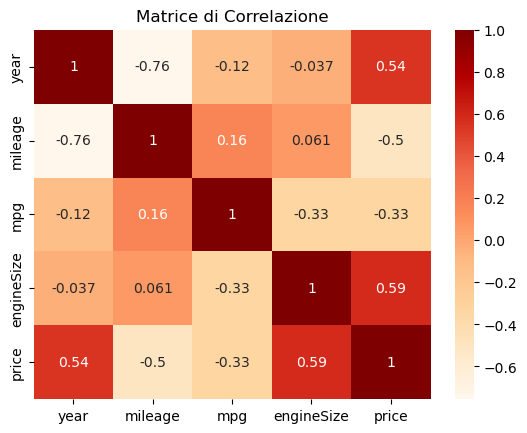

In [38]:
correlation_matrix = dataset.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='OrRd')
plt.title('Matrice di Correlazione')
plt.show()

<h3> Distribuzione delle variabili categoriche</h3>

<h4> Distribuzione delle variabili categoriche rapportate al numero di auto</h4>

In [39]:
# Elenco delle variabili categoriche da visualizzare
categorical_features = ['manufacturer', 'transmission', 'fuelType']

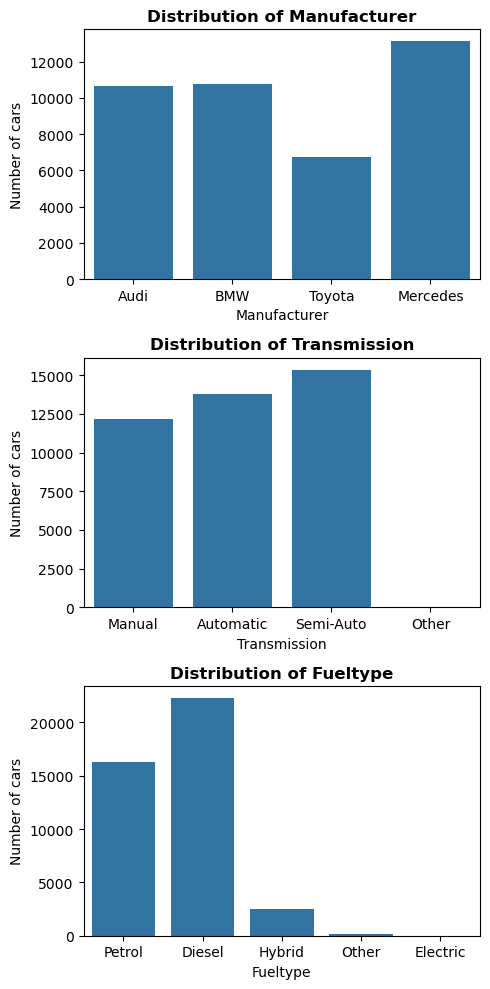

In [40]:
fig, axes = plt.subplots(len(categorical_features), 1, figsize=(5, 10), sharex=False)

for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, data=dataset, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature.capitalize()}',fontweight='bold')
    axes[i].set_xlabel(feature.capitalize())
    axes[i].set_ylabel('Number of cars')

plt.tight_layout()
plt.show()

<h5> Osservazioni </h5>
Nel dataset fornito, si osserva una minor presenza di auto Toyota rispetto ad altri marchi, mentre le auto della Mercedes sono le più rappresentate. Inoltre, il tipo di trasmissione più comune è la semi-automatica, e la maggior parte dei veicoli è equipaggiata con un motore diesel.

<h4> Distribuzione variabili categoriche rapportate al prezzo </h4>

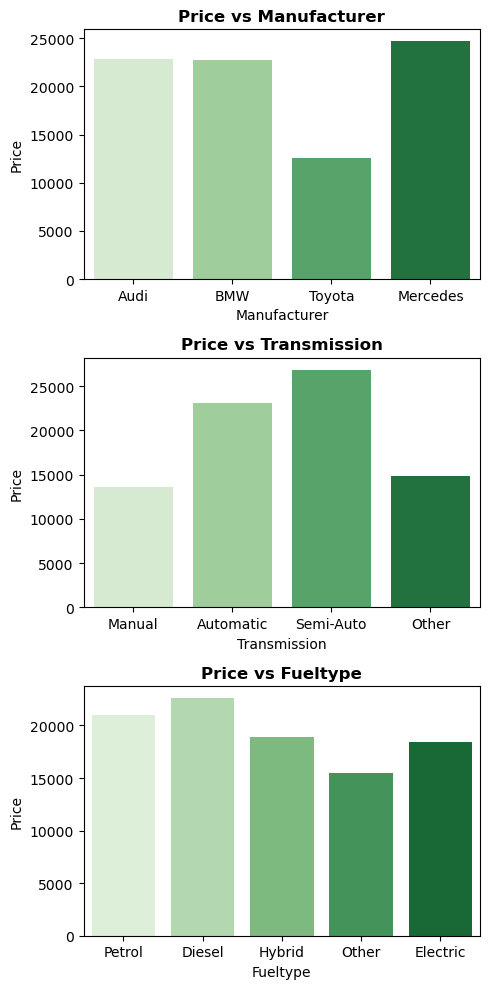

In [41]:
fig, axes = plt.subplots(len(categorical_features), 1, figsize=(5, 10), sharex=False)

for i, feature in enumerate(categorical_features):
    sns.barplot(data=dataset, x=feature, y='price', palette="Greens", errorbar=None, ax=axes[i], dodge=False, hue=feature, legend=False)
    axes[i].set_title(f'Price vs {feature.capitalize()}', fontweight='bold') 
    axes[i].set_xlabel(feature.capitalize())
    axes[i].set_ylabel('Price')
    axes[i].tick_params(axis='x')

plt.tight_layout()
plt.show()

<h4> Osservazioni sui Prezzi delle Auto</h4>

- **Prezzo per Fabbricante**:
  Notiamo come Mercedes produca vetture leggermente più costose di Audi e BMW, mentre Toyota si posiziona con prezzi mediamente più bassi.

- **Prezzo per Tipo di Trasmissione e Carburante**:
  Generalmente, troviamo prezzi più alti per auto con cambio semi-automatico e per quelle alimentate a diesel.


<h2> Pulizia dati</h2>

<h3> Controllo di valori mancanti, duplicati o inconsistenti </h3>

<h4> Dati mancanti</h4>

In [42]:
# Controllo la presenza di dati mancanti per ogni colonna
missing_data = dataset.isnull().sum()
print("Dati Mancanti per Colonna:")
print(missing_data)

# Controllo il totale dei dati mancanti nel dataset
total_missing = missing_data.sum()
print(f"\nTotale Dati Mancanti: {total_missing}")

# Rimozione righe con dati mancanti
dataset_cleaned = dataset.dropna()
print(f"\nNumero di righe dopo la rimozione dei dati mancanti: {dataset_cleaned.shape[0]}")


Dati Mancanti per Colonna:
manufacturer    0
model           0
year            0
transmission    0
mileage         0
fuelType        0
mpg             0
engineSize      0
price           0
dtype: int64

Totale Dati Mancanti: 0

Numero di righe dopo la rimozione dei dati mancanti: 41306


<h4> Dati inconsistenti</h4>

In [43]:
# Opero solo su colonne numeriche
numeric_columns = dataset_cleaned.select_dtypes(include=['number'])

# Controlla la presenza di valori negativi per ogni colonna numerica
negative_data = (numeric_columns < 0).sum()
print("Valori Negativi per Colonna Numerica:")
print(negative_data)

# Controlla il totale dei valori negativi nel dataset
total_negative = negative_data.sum()
print(f"\nTotale Valori Negativi: {total_negative}")

# Rimozione righe con valori negativi
dataset_cleaned = dataset_cleaned[(numeric_columns >= 0).all(axis=1)]
print(f"\nNumero di righe dopo la rimozione dei valori negativi: {dataset_cleaned.shape[0]}")


Valori Negativi per Colonna Numerica:
year          0
mileage       0
mpg           0
engineSize    0
price         0
dtype: int64

Totale Valori Negativi: 0

Numero di righe dopo la rimozione dei valori negativi: 41306


<h4> Dati negativi </h4>

In [44]:
num_duplicates = dataset_cleaned.duplicated().sum()

# Rimozione righe duplicate
dataset_unique = dataset_cleaned.drop_duplicates()

# Conteggio del numero di righe duplicate rimosse
num_removed_duplicates = dataset_cleaned.shape[0] - dataset_unique.shape[0]
print(f"Le righe duplicate rimosse sono: {num_removed_duplicates}")

print(f"\nNumero finale di righe: {dataset_unique.shape[0]}")


Le righe duplicate rimosse sono: 563

Numero finale di righe: 40743


<h3> Outliers</h3>

Gli outlier sono valori che si discostano significativamente dalla distribuzione normale dei dati. 

Per identificare gli outlier, è comune utilizzare l'intervallo interquartile (IQR), calcolato come segue:
$$\text{IRQ} = \text{Q3} - \text{Q1} $$



Dove **Q1** è il primo quartile (25° percentile) e **Q3** è il terzo quartile (75° percentile)
- Valori inferiori a $\text{Q1} - 1.5 \times \text{IQR}$ sono considerati outlier inferiori.
- Valori superiori a $\text{Q3} + 1.5 \times \text{IQR}$ sono considerati outlier superiori.


In [45]:
# Seleziono solo le colonne numeriche
numerical_columns = dataset.select_dtypes(include=[np.number])

print("Numero di righe prima della rimozione degli outliers:", dataset.shape[0])

# Calcolo il primo e il terzo quartile per ogni variabile numerica
Q1 = numerical_columns.quantile(0.25)
Q3 = numerical_columns.quantile(0.75)

# Calcolo (IQR) per ogni variabile numerica
IQR = Q3 - Q1

# Calcolo i limiti inferiori e superiori per gli outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifico e rimuovo le righe che contengono outliers
outliers = numerical_columns[((numerical_columns < lower_bound) | (numerical_columns > upper_bound)).any(axis=1)]
dataset_cleaned = dataset[~((numerical_columns < lower_bound) | (numerical_columns > upper_bound)).any(axis=1)]


print("Numero di righe dopo la rimozione degli outliers:", dataset_cleaned.shape[0])
print("Righe rimosse (outliers):")
print(outliers)


Numero di righe prima della rimozione degli outliers: 41306
Numero di righe dopo la rimozione degli outliers: 37090
Righe rimosse (outliers):
       year  mileage   mpg  engineSize   price
6      2016    76788  61.4         2.0   13250
43     2014    83872  58.9         2.0   13200
54     2015    89483  47.1         2.0   14700
60     2013    76269  74.3         1.6    7000
66     2016    97440  70.6         2.0   10200
...     ...      ...   ...         ...     ...
41243  2020     1159  32.8         2.9   58450
41245  2015    23156  28.0         5.5   51990
41247  2017     1755  24.8         4.0  109495
41248  2019     3179  36.2         2.0   46995
41305  2019     2075  52.3         2.9   54999

[4216 rows x 5 columns]


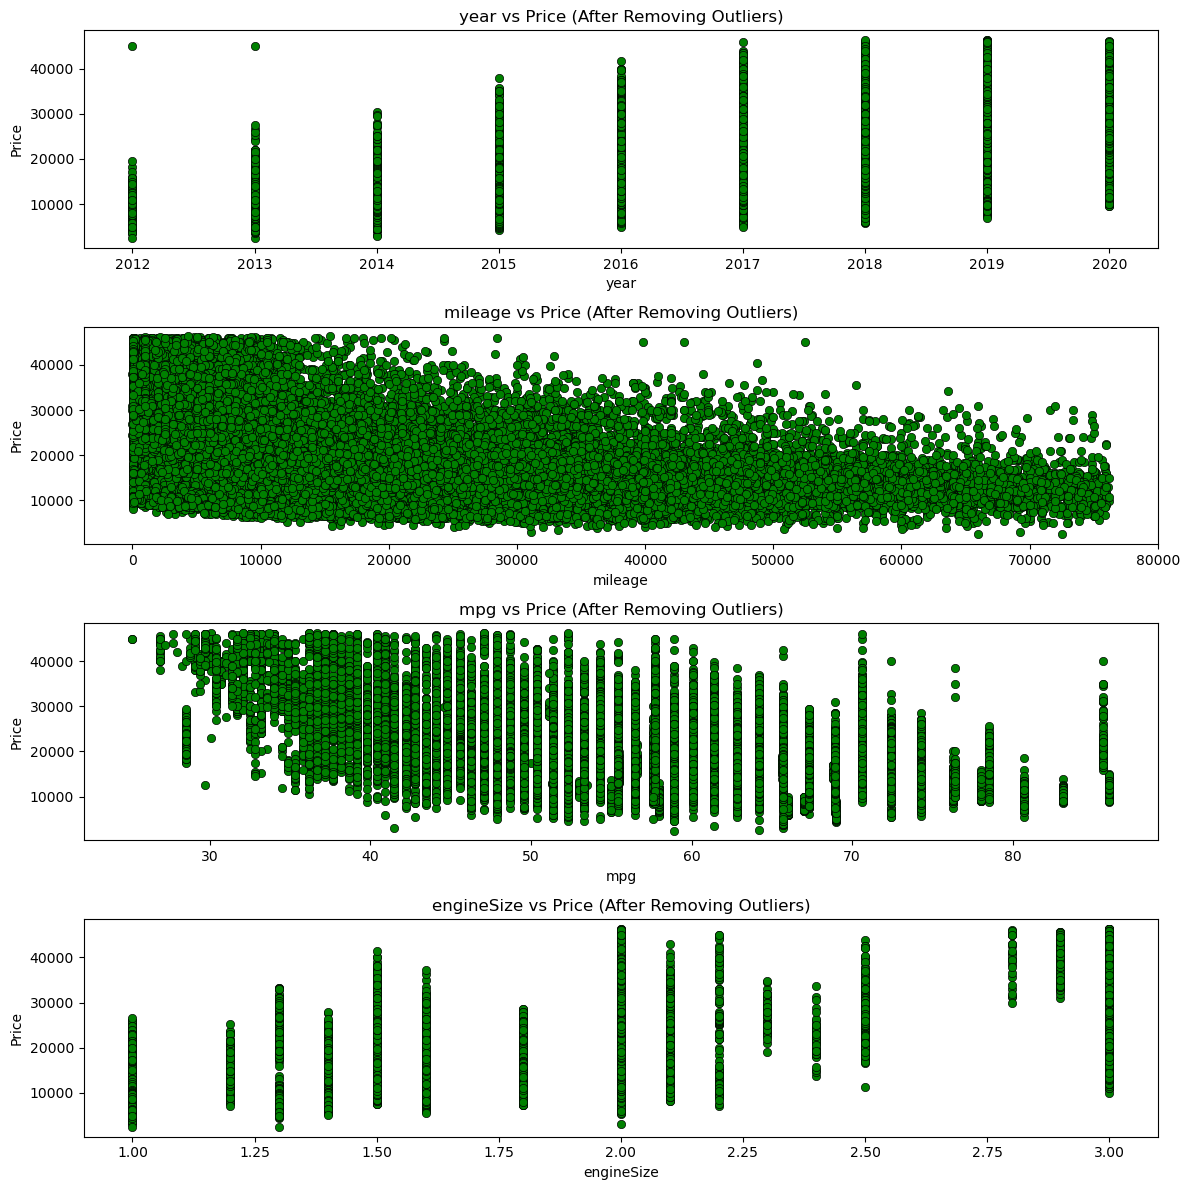

In [46]:
# Grafico post pulizia
fig, axes = plt.subplots(len(numerical_features), 1, figsize=(12, 12), sharex=False)

for i, feature in enumerate(numerical_features):
    sns.scatterplot(x=feature, y='price', data=dataset_cleaned, ax=axes[i], color='green', edgecolor='black')
    axes[i].set_title(f'{feature} vs Price (After Removing Outliers)')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Price')

plt.tight_layout()
plt.show()

<h2> Preparazione modelli di regressione</h2>


<h4> Trasformazione delle variabili categoriche in binarie</h4>

Trasformo le variabili categoriche (come il produttore dell'auto e il tipo di trasmissione) in formato numerico attraverso la *tecnica della codifica one-hot*. 

Questo processo crea una colonna separata per ciascuna categoria unica di queste variabili, con valori 0 o 1 che indicano la presenza o l'assenza di quella categoria per ciascuna riga.

In [47]:
# Codifica delle variabili categoriche
dataset_encoded = pd.get_dummies(dataset, columns=['manufacturer', 'model', 'fuelType', 'transmission'])

# Separa le features e il target
X = dataset_encoded.drop('price', axis=1)
y = dataset_encoded['price']

<h4> Generazione di training e testing set</h4>

In [48]:
# Suddivisione dei dati in set di addestramento e test, 20% per il testing, il seed è 123456 (per la replicazione)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123456)

<h4>Normalizzazione</h4>

La standardizzazione trasforma i dati affinché abbiano una media di 0 e una deviazione standard di 1.



In [49]:
# Creazione dello StandardScaler
scaler = StandardScaler()

# Addestramento dello scaler e trasformazione di X_train
X_train_scaled = scaler.fit_transform(X_train) #fit_transform perchè calcolo le statistiche e normalizzo.

# Trasformazione di X_test
X_test_scaled = scaler.transform(X_test) #solo transform perchè non calcolo le statistiche, uso quelle del training.

<h2> Addestramento e Predizione</h2>

<h4> Metriche</h4>

- **R² (coefficiente di determinazione)**: misura la proporzione della varianza nei dati che è spiegata dal modello. Un valore di R² vicino a 1 indica che il modello riesce a spiegare bene i dati, mentre un valore più basso indica il contrario. È utile per valutare quanto bene il modello si adatta al set di dati complessivo.

- **MAE (errore assoluto medio)**: fornisce una misura dell'accuratezza del modello, calcolando la media delle differenze assolute tra i valori previsti e quelli reali. È particolarmente utile per interpretare facilmente quanto, in media, il modello sbaglia nella previsione dei prezzi in termini assoluti.

In [50]:
# Usati per memorizzare e confrontare i risultati.
models=[] # Nome del modello
maes=[]   # Errore medio assoluto
r2s=[]    # Coefficiente di determinazione.


<h3> K-neighbors </h3>

E' un algoritmo utilizzato nel riconoscimento di pattern per la classificazione di oggetti basandosi sulle caratteristiche degli oggetti vicini a quello considerato. L'identificazione del K ottimale è ottenuta mediante *K-fold cross validation*. Tramite *randomfit* cerchiamo di migliorare le tempistiche per la previsione.

Best hyperparameters: {'n_neighbors': 3}
Mean Absolute Error (Train): 1115.09
R^2 Score (Train): 0.97
Mean Absolute Error (Test): 1673.05
R^2 Score (Test): 0.94


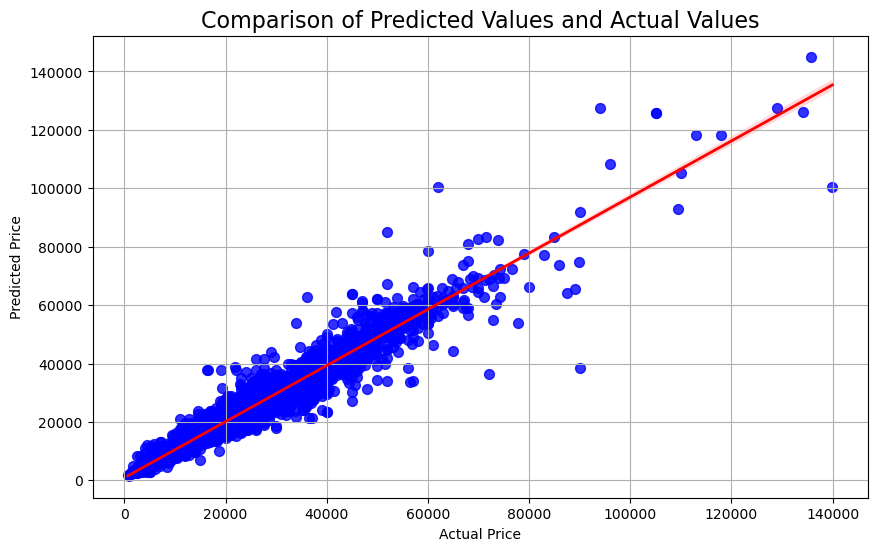

In [51]:
# Creazione e ricerca dei migliori parametri per K-Nearest Neighbors
param_grid = {'n_neighbors': np.arange(1, 21)}

random_search = RandomizedSearchCV(
    KNeighborsRegressor(),                    # Il modello di regressione KNN da ottimizzare
    param_distributions=param_grid,           # La griglia dei parametri da esplorare
    n_iter=10,                                # Numero di combinazioni di parametri da testare (10)
    cv=5,                                     # Numero di fold per k-fold cross validation (5)
    scoring='neg_mean_absolute_error',        # Metodologia per valutare le prestazioni dei modelli (MAE negativo)
    n_jobs=-1,                                # Uso tutte le CPU
    random_state=123456                       # Seed per riproducibilità
)
random_search.fit(X_train_scaled, y_train)

# Ottenimento dei migliori iperparametri
best_k = random_search.best_params_['n_neighbors']
print("Best hyperparameters:", random_search.best_params_)

# Addestro il modello con questi iperparametri trovati
knn_model = KNeighborsRegressor(n_neighbors=best_k)
knn_model.fit(X_train_scaled, y_train)

# Previsioni training e testing
train_y_pred = knn_model.predict(X_train_scaled)
y_predict = knn_model.predict(X_test_scaled)

# Valutazione training
mae_train = mean_absolute_error(y_train, train_y_pred)
r2_train = r2_score(y_train, train_y_pred)

# Valutazione testing
mae_test = mean_absolute_error(y_test, y_predict)
r2_test = r2_score(y_test, y_predict)

# Stampa dei risultati
print(f"Mean Absolute Error (Train): {mae_train:.2f}")
print(f"R^2 Score (Train): {r2_train:.2f}")
print(f"Mean Absolute Error (Test): {mae_test:.2f}")
print(f"R^2 Score (Test): {r2_test:.2f}")

# Salvataggio per confronto
models.append('K-Nearest Neighbors')
maes.append(mae_test)
r2s.append(r2_test)

# Grafico dei risultati
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_predict, scatter_kws={'s':50, 'color':'blue'}, line_kws={'color':'red', 'linewidth':2})
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('K-neighbors: Predicted Prices vs Actual Prices', fontsize=16)
plt.grid(True)
plt.show()

<h3> Regressione Lineare</h3>

<h4>Descrizione della Regressione Lineare</h4> 

La **regressione lineare** è una tecnica statistica che modella la relazione tra una variabile dipendente e una o più variabili indipendenti attraverso una retta. Essa stima i parametri del modello per minimizzare la differenza tra i valori osservati e quelli previsti dal modelldati.

Mean Absolute Error (Test): 2995.4661201888525
R^2 Score (Test): 0.8333118612597311
Mean Absolute Error (Train): 2997.2855711931384
R^2 Score (Train): 0.8299547620294545


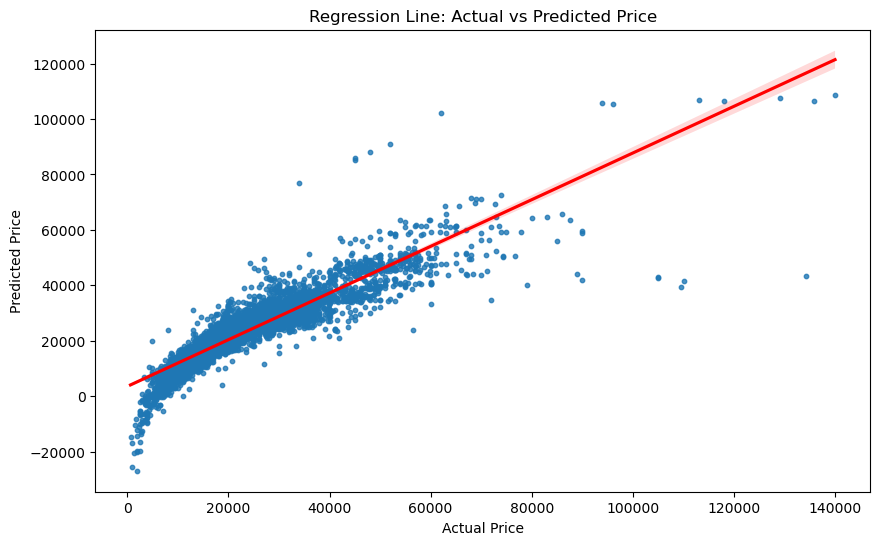

In [52]:
# Crea il modello di regressione lineare
model = LinearRegression()

# Allena il modello sui dati di addestramento (non normalizzati), X_train sono le features, y_train le etichette
model.fit(X_train, y_train)

# Previsioni sul training
train_y_pred = model.predict(X_train)  

# Previsioni sul testing
y_pred = model.predict(X_test)


# Valutazione prestazioni
mae_train = mean_absolute_error(y_train, train_y_pred)
r2_train = r2_score(y_train, train_y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

# Stampa dei risultati
print(f"Mean Absolute Error (Test): {mae_test}")
print(f"R^2 Score (Test): {r2_test}")
print(f"Mean Absolute Error (Train): {mae_train}")
print(f"R^2 Score (Train): {r2_train}")

# Salvataggio per confronto
models.append('LinearRegression')
maes.append(mae_test)
r2s.append(r2_test)

# Grafico dei risultati
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s':10}, line_kws={'color':'red'})
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Regression Line: Predicted Prices vs Actual Prices')
plt.show()


<h3> Ridge, L2 Regularization</h3>

La **Regressione Ridge (L2 Regularization)** è una tecnica di regressione lineare che include un termine di penalizzazione sui coefficienti del modello. Questa penalizzazione aiuta a ridurre l'overfitting e a migliorare la generalizzazione, soprattutto quando ci sono molte caratteristiche o dati altamente correlati. L2 Regularization aggiunge la somma dei quadrati dei coefficienti al termine di costo, penalizzando i coefficienti grandi e mantenendoli più piccoli.

Mean Absolute Error (Train): 2997.27
R^2 Score (Train): 0.83
Mean Absolute Error (Test): 2995.60
R^2 Score (Test): 0.83


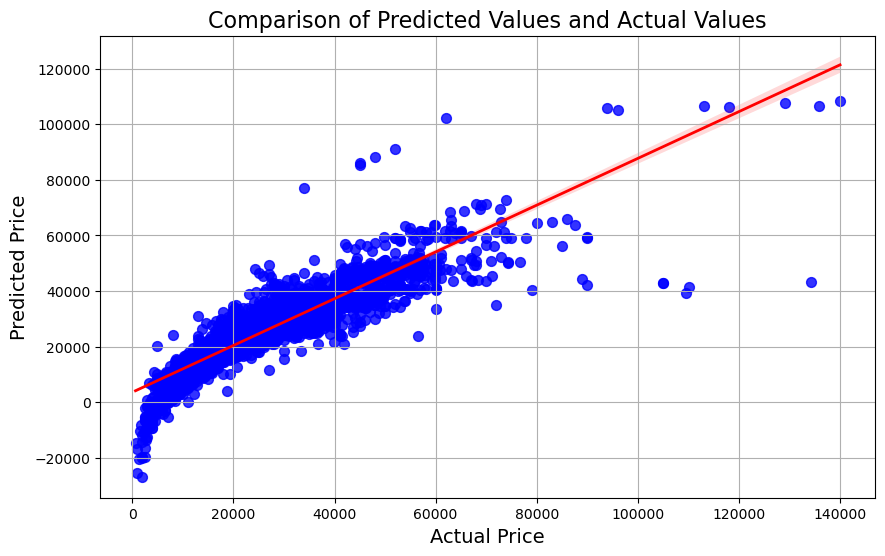

In [53]:
ridge_model = Ridge(alpha=1.0)  # alpha è il parametro di regolarizzazione

# Allena il modello sui dati di addestramento
ridge_model.fit(X_train_scaled, y_train)

# Previsioni training e testing
y_pred_train = ridge_model.predict(X_train_scaled)
y_pred_test = ridge_model.predict(X_test_scaled)


# Valutazione prestazioni
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Stampa dei risultati
print(f"Mean Absolute Error (Train): {mae_train:.2f}")
print(f"R^2 Score (Train): {r2_train:.2f}")

print(f"Mean Absolute Error (Test): {mae_test:.2f}")
print(f"R^2 Score (Test): {r2_test:.2f}")

# Salvataggio per confronto
models.append('L2 Regression')
maes.append(mae_test)
r2s.append(r2_test)


# Grafico dei risultati
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s':50, 'color':'blue'}, line_kws={'color':'red', 'linewidth':2})
plt.xlabel('Actual Price', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.title('L2 Regularization: Predicted Prices vs Actual Prices', fontsize=16)
plt.grid(True) 
plt.show()

<h3> Random Forest </h3>

Mean Absolute Error (Train): 549.14
R^2 Score (Train): 0.99
Mean Absolute Error (Test): 1460.46
R^2 Score (Test): 0.96


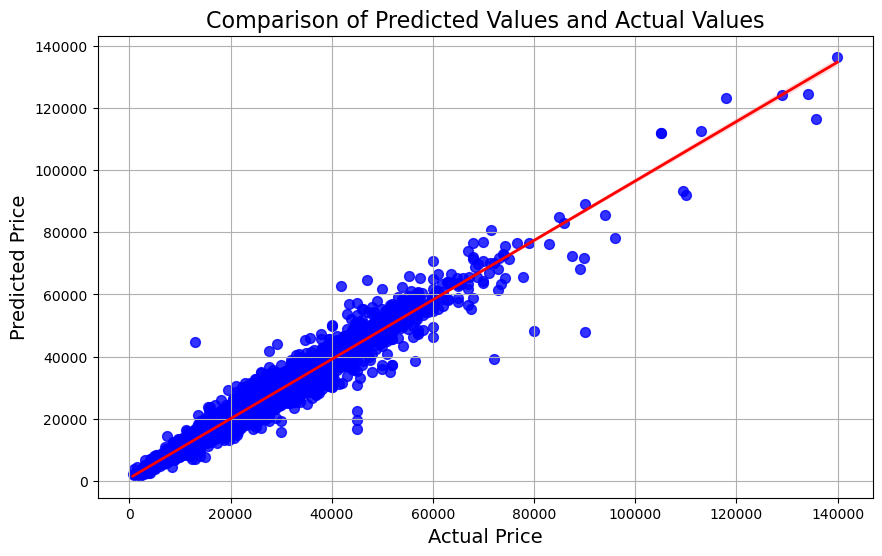

In [54]:
# Creazione del modello Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=123456)  # Puoi aggiungere altri parametri se necessario

# Addestramento del modello sui dati di addestramento
rf_model.fit(X_train_scaled, y_train)

# Previsioni training e testing
y_pred_train = rf_model.predict(X_train_scaled)
y_pred_test = rf_model.predict(X_test_scaled)

# Valutazione prestazioni
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Stampa dei risultati
print(f"Mean Absolute Error (Train): {mae_train:.2f}")
print(f"R^2 Score (Train): {r2_train:.2f}")
print(f"Mean Absolute Error (Test): {mae_test:.2f}")
print(f"R^2 Score (Test): {r2_test:.2f}")

# Salvataggio per confronto
models.append('Random Forest')
maes.append(mae_test)
r2s.append(r2_test)

# Grafico dei risultati
plt.figure(figsize=(10, 6))  
sns.regplot(x=y_test, y=y_pred_test, scatter_kws={'s':50, 'color':'blue'}, line_kws={'color':'red', 'linewidth':2})
plt.xlabel('Actual Price', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.title('Random Forest: Predicted Prices vs Actual Prices', fontsize=16)
plt.grid(True)
plt.show()

<h3> AdaBoost</h3>

Con **AdaBoost**, il processo consiste nell'addestrare iterativamente una serie di classificatori, partendo da un *weak classifier*. Inizialmente, questo classificatore viene valutato in base agli errori commessi. Successivamente, gli errori vengono pesati maggiormente, e i dati vengono riproposti a una nuova istanza del classificatore, permettendo così di concentrarsi sugli errori precedentemente commessi. Questo approccio mira a migliorare le performance complessive combinando i risultati di più classificatori. Tuttavia, il risultato finale potrebbe non essere ottimale in contesti lineari come il nostro, poiché il modello tende a ottimizzare le aree circoscritte dalle linee prodotte dai classificatori, che potrebbero non adattarsi perfettamente a relazioni lineari nei dati.

mae_training: 7031.99
r2_training: 0.48
mae_testing: 6956.33
r2_testing: 0.49


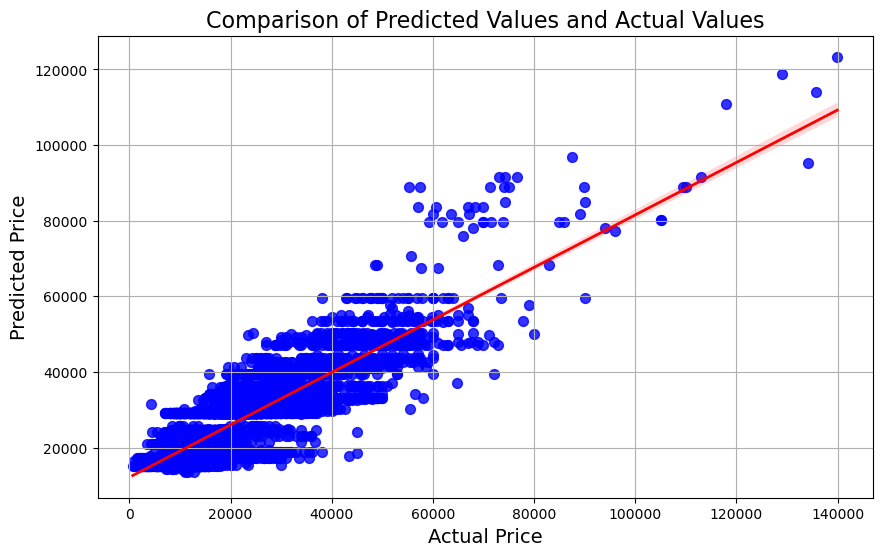

In [59]:
# Creazione del modello AdaBoost Regressor con il regressore base predefinito
ada_model = AdaBoostRegressor(
    n_estimators=100,  # Numero di stadi nella sequenza di boosting
    random_state=123456  # Seme per garantire la riproducibilità
)

# Addestramento del modello sui dati normalizzati
ada_model.fit(X_train_scaled, y_train)

# Previsioni training e testing
train_y_pred = ada_model.predict(X_train_scaled)
y_pred = ada_model.predict(X_test_scaled)


# Valutazione prestazioni
ada_mae_train = mean_absolute_error(y_train, train_y_pred)
ada_r2_train = r2_score(y_train, train_y_pred)

ada_mae = mean_absolute_error(y_test, y_pred)
ada_r2 = r2_score(y_test, y_pred)

# Stampa dei risultati
print(f'mae_training: {ada_mae_train:.2f}')
print(f'r2_training: {ada_r2_train:.2f}')

print(f'mae_testing: {ada_mae:.2f}')
print(f'r2_testing: {ada_r2:.2f}')

# Salvataggio per confronto
models.append('AdaBoost')
maes.append(ada_mae)
r2s.append(ada_r2)

# Grafico dei risultati
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s':50, 'color':'blue'}, line_kws={'color':'red', 'linewidth':2})
plt.xlabel('Actual Price', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.title('AdaBoost: Predicted Prices vs Actual Prices', fontsize=16)
plt.grid(True)
plt.show()


<h3> Reti Neurali</h3>

Le reti neurali artificiali sono modelli ispirati al cervello umano, costituiti da strati di neuroni che apprendono relazioni complesse tra i dati. Creeremo un modello con tre strati: un primo strato con 64 neuroni e funzione di attivazione ReLU per l'input, un secondo strato nascosto con 32 neuroni e ReLU, e un ultimo strato di output con un neurone per la regressione. Il modello utilizza l'ottimizzatore Adam (combinazione dei meccanismi di *RMSProp* e *Momentum*) e l'errore quadratico medio come funzione di perdita. Per prevenire l'overfitting, è implementato un meccanismo di **early stopping** che interrompe l'addestramento se non ci sono miglioramenti dopo 5 epoche, ripristinando i pesi migliori. Successivamente proveremo a implementare una nuova rete neurale, cercando di ottimizzare svariati parametri.


In [60]:
model = Sequential()

# Composizione strati modello
model.add(Dense(units=64, activation='relu', input_shape=(X_train_scaled.shape[1],)))  # Primo strato
model.add(Dense(units=32, activation='relu'))  # Strato nascosto
model.add(Dense(units=1))  # Strato di output per la regressione (1 unità)

model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitora la funzione di perdita sul set di validazione
    patience=5,            # Aspetta 5 epoche senza miglioramenti
    restore_best_weights=True  # Ripristina i pesi migliori alla fine dell'addestramento
)

# Addestramento
model.fit(X_train_scaled, y_train, epochs=30, batch_size=32, validation_data=(X_test_scaled, y_test))


Epoch 1/30
1033/1033 [==============================] - 4s 3ms/step - loss: 372775424.0000 - val_loss: 76824008.0000
Epoch 2/30
1033/1033 [==============================] - 3s 3ms/step - loss: 47435568.0000 - val_loss: 34793828.0000
Epoch 3/30
1033/1033 [==============================] - 3s 3ms/step - loss: 29350856.0000 - val_loss: 27259850.0000
Epoch 4/30
1033/1033 [==============================] - 3s 3ms/step - loss: 24580112.0000 - val_loss: 24423762.0000
Epoch 5/30
1033/1033 [==============================] - 3s 3ms/step - loss: 22203380.0000 - val_loss: 22731630.0000
Epoch 6/30
1033/1033 [==============================] - 3s 3ms/step - loss: 20638908.0000 - val_loss: 21441156.0000
Epoch 7/30
1033/1033 [==============================] - 3s 3ms/step - loss: 19552652.0000 - val_loss: 20627420.0000
Epoch 8/30
1033/1033 [==============================] - 3s 3ms/step - loss: 18711880.0000 - val_loss: 19774848.0000
Epoch 9/30
1033/1033 [==============================] - 3s 3ms/step - l

259/259 [==============================] - 0s 2ms/step
Mean Absolute Error (Train): 1941.22
R^2 Score (Train): 0.92
Mean Absolute Error (Test): 1979.03
R^2 Score (Test): 0.92


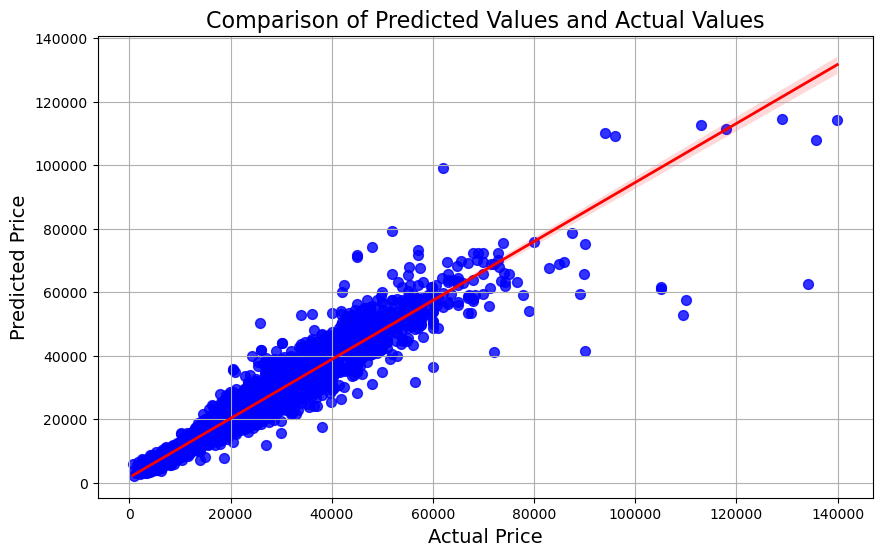

In [61]:
# Previsioni training e testing
train_y_pred = model.predict(X_train_scaled)
y_pred = model.predict(X_test_scaled)

# Valutazione prestazioni
nn_mae_train = mean_absolute_error(y_train, train_y_pred)
nn_r2_train = r2_score(y_train, train_y_pred)

nn_mae = mean_absolute_error(y_test, y_pred)
nn_r2 = r2_score(y_test, y_pred)


#Stampa dei risultati 
print(f"Mean Absolute Error (Train): {nn_mae_train:.2f}")
print(f"R^2 Score (Train): {nn_r2_train:.2f}")

print(f"Mean Absolute Error (Test): {nn_mae:.2f}")
print(f"R^2 Score (Test): {nn_r2:.2f}")


# Salvataggio per confronto
models.append('NN Early Stopping')
maes.append(nn_mae)
r2s.append(nn_r2)

# Grafico dei risultati
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s':50, 'color':'blue'}, line_kws={'color':'red', 'linewidth':2})
plt.xlabel('Actual Price', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.title('NN: Predicted Prices vs Actual Prices', fontsize=16)
plt.grid(True) 
plt.show()


<h3> Reti neurali con Keras Tuner </h3>

Adesso definiamo la funzione `model_builder`, che costruisce un modello con un numero di unità nello strato nascosto e un tasso di apprendimento variabili, da *ottimizzare*. Utilizza `Hyperband` per trovare i migliori iperparametri, testando diverse configurazioni. L'early stopping previene l'overfitting monitorando la performance del modello durante l'addestramento e fermando l'addestramento se non ci sono miglioramenti.

Reloading Tuner from .\keras_tuner_search\tuner0.json

I migliori iperparametri trovati sono:
- Numero di unità nello strato nascosto: 96
- Learning rate: 0.01

Epoch 1/30
1033/1033 [==============================] - 5s 4ms/step - loss: 9505.2773 - mean_absolute_error: 9505.2773 - val_loss: 3415.2170 - val_mean_absolute_error: 3415.2170
Epoch 2/30
1033/1033 [==============================] - 3s 3ms/step - loss: 2965.1995 - mean_absolute_error: 2965.1995 - val_loss: 2721.1812 - val_mean_absolute_error: 2721.1812
Epoch 3/30
1033/1033 [==============================] - 3s 3ms/step - loss: 2541.0369 - mean_absolute_error: 2541.0369 - val_loss: 2458.6541 - val_mean_absolute_error: 2458.6541
Epoch 4/30
1033/1033 [==============================] - 3s 3ms/step - loss: 2367.7817 - mean_absolute_error: 2367.7817 - val_loss: 2322.0349 - val_mean_absolute_error: 2322.0349
Epoch 5/30
1033/1033 [==============================] - 3s 3ms/step - loss: 2262.3066 - mean_absolute_error: 2262.3066 - val_lo

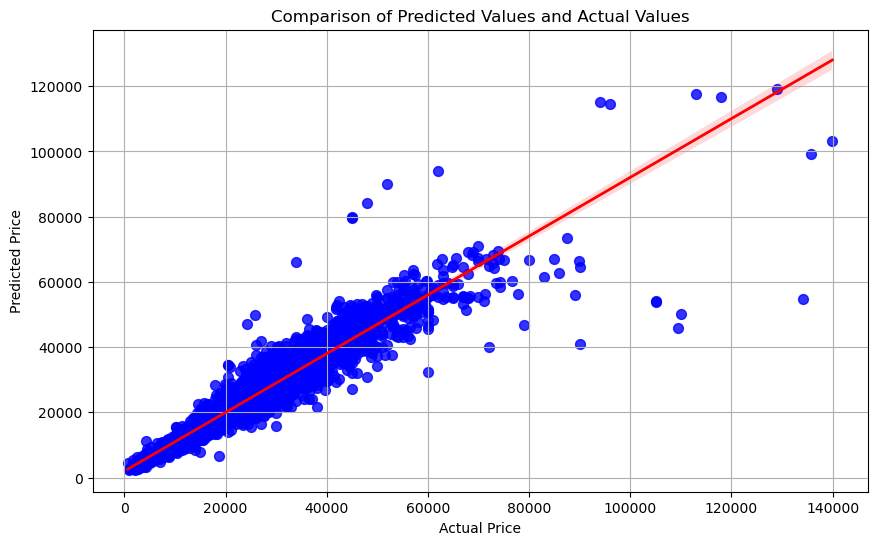

In [62]:
# Definizione del costruttore di modelli
def model_builder(hp):
    nn = Sequential()
    
    # Primo strato con un numero di unità ottimizzato
    nn.add(Dense(units=hp.Int('units', min_value=32, max_value=128, step=32),
                 activation='relu', input_dim=X_train_scaled.shape[1]))
    
    # Strato di output
    nn.add(Dense(1))  # Uscita per regressione

    # Ottimizzazione del tasso di apprendimento
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
               loss='mean_absolute_error',
               metrics=['mean_absolute_error'])
    return nn

# Inizializzazione del tuner per la ricerca degli iperparametri
tuner = kt.Hyperband(
    model_builder,                        # Funzione che costruisce il modello
    objective='val_mean_absolute_error',  # Ottimizza MAE sulla validation
    max_epochs=30,                        # Numero massimo di epoche
    project_name='keras_tuner_search'
)

# Implementazione l'early stopping
early_stopping = EarlyStopping(monitor='val_mean_absolute_error', patience=5)

# Ricerca per gli iperparametri
tuner.search(X_train_scaled, y_train, epochs=30, validation_split=0.2, callbacks=[early_stopping])

# Recupero dei migliori iperparametri
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Stampa risultati
print(f"""
I migliori iperparametri trovati sono:
- Numero di unità nello strato nascosto: {best_hps.get('units')}
- Learning rate: {best_hps.get('learning_rate')}
""")

# Creazione del modello ottimale
nn_model = tuner.hypermodel.build(best_hps)

# Addestramento del modello
history = nn_model.fit(X_train_scaled, y_train, epochs=30, validation_data=(X_test_scaled, y_test), callbacks=[early_stopping])

# Previsioni training e testing
train_y_pred = nn_model.predict(X_train_scaled)
y_predict = nn_model.predict(X_test_scaled)

# Valutazione del modello
nn_mae_train = mean_absolute_error(y_train, train_y_pred)
nn_r2_train = r2_score(y_train, train_y_pred)

nn_mae_test = mean_absolute_error(y_test, y_predict)
nn_r2_test = r2_score(y_test, y_predict)

# Stampa dei risultati 
print(f"Mean Absolute Error (Train): {nn_mae_train:.2f}")
print(f"R^2 Score (Train): {nn_r2_train:.2f}")

print(f"Mean Absolute Error (Test): {nn_mae_test:.2f}")
print(f"R^2 Score (Test): {nn_r2_test:.2f}")


# Salvataggio per confronto
models.append('Keras Network')
maes.append(nn_mae_test)
r2s.append(nn_r2_test)

# Grafico dei risultati
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_predict, scatter_kws={'s':50, 'color':'blue'}, line_kws={'color':'red', 'linewidth':2})
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('NN with Keras Tuner: Predicted Prices vs Actual Prices')
plt.grid(True)
plt.show()


<h2> Conclusioni </h2>

<h3> Grafico $R^2$

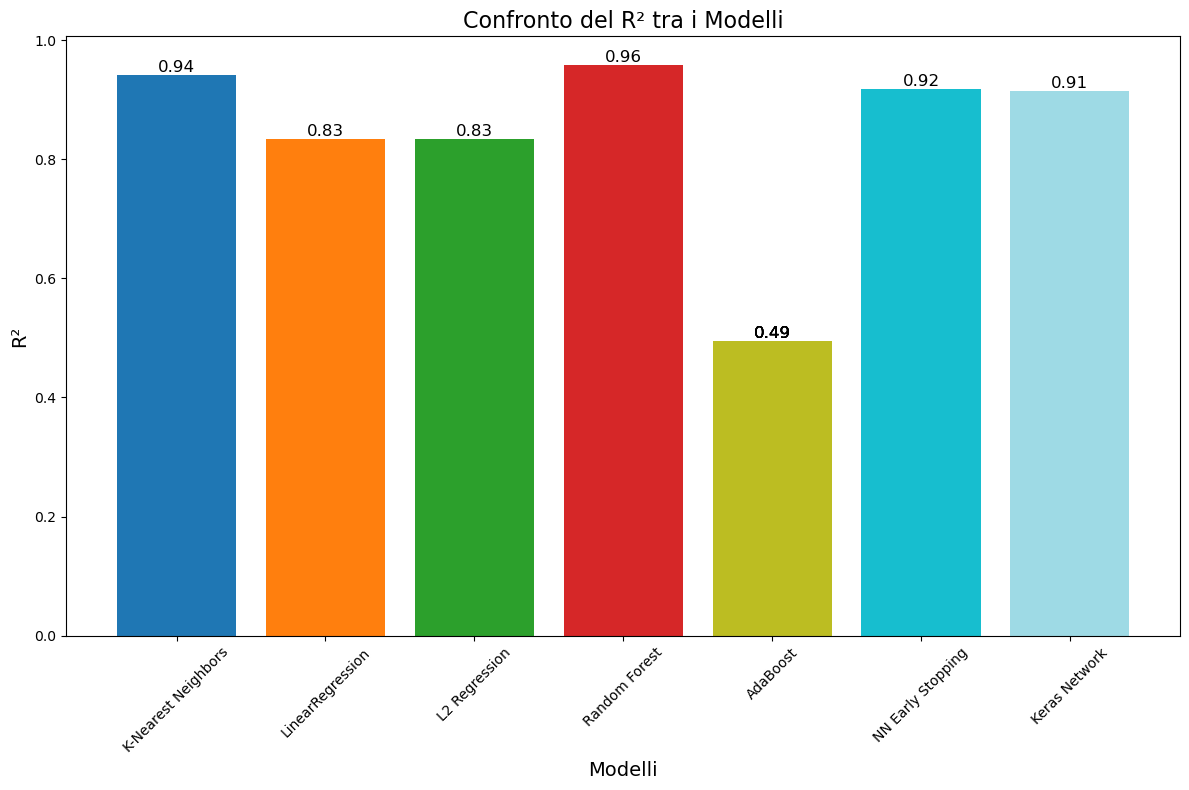

In [65]:
# Definizione dei colori
num_models = len(models)
colors = plt.get_cmap('tab20')(np.linspace(0, 1, num_models))

# Grafico per il R² dei vari modelli
plt.figure(figsize=(12, 8))
bars = plt.bar(models, r2s, color=colors)

# Aggiunta dei valori precisi sopra le barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', va='bottom', ha='center', fontsize=12)

# Migliora l'aspetto del grafico
plt.title('Confronto del R² tra i Modelli', fontsize=16)
plt.xlabel('Modelli', fontsize=14)
plt.ylabel('R²', fontsize=14)
plt.xticks(rotation=45, fontsize=10)  # Riduce la dimensione del font delle etichette sull'asse delle x
plt.tight_layout()

# Mostra il grafico
plt.show()

<h3> Osservazioni </h3>
Ricordiamo che:

- Un **$R^2$** vicino a 1 significa che il modello spiega bene la variabilità dei dati.
- Un **$R^2$** vicino a 0 indica che il modello non spiega bene la variabilità dei dati.

Tuttavia, un valore molto alto di **$R^2$** non sempre garantisce un buon modello. È importante considerare anche altri aspetti come la qualità dei dati, la complessità del modello e la possibilità di overfitting (il modello si adatta troppo ai dati di addestramento ma non generalizza bene ai dati nuovi).

Sotto tale metrica, **Random Forest** si comporta meglio.

<h3> Grafico MAE </h3>

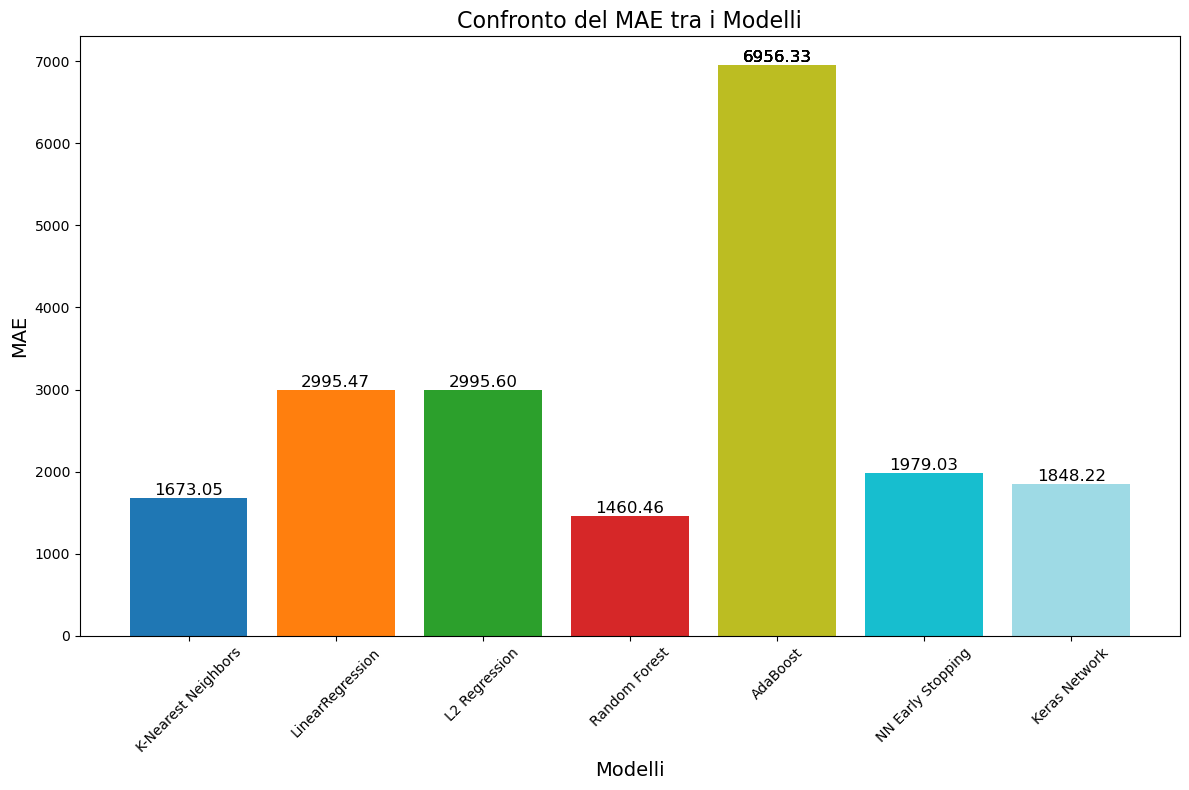

In [66]:
# Grafico per il MAE dei vari modelli
plt.figure(figsize=(12, 8))
bars = plt.bar(models, maes, color=colors)

# Aggiunta dei valori precisi sopra le barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', va='bottom', ha='center', fontsize=12)

# Migliora l'aspetto del grafico
plt.title('Confronto del MAE tra i Modelli', fontsize=16)
plt.xlabel('Modelli', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.xticks(rotation=45, fontsize=10)  # Riduce la dimensione del font delle etichette sull'asse delle x
plt.tight_layout()

# Mostra il grafico
plt.show()


<h4> Osservazioni </h4>

Il **MAE** è la media delle differenze assolute tra i valori predetti e quelli osservati.

- Un **MAE** basso significa che le previsioni del modello sono, in media, molto vicine ai valori reali.
- Un **MAE** alto indica che le previsioni sono lontane dai valori reali, quindi il modello ha una performance peggiore.

A differenza di **$R^2$**, che è una misura relativa, il **MAE** fornisce un valore assoluto che rappresenta direttamente l'errore medio in unità della variabile dipendente. Di conseguenza, è utile per comprendere la magnitudine dell'errore del m

Anche in questo caso, il modello che si comporta meglio è **Random Forest**.

<h3> Conclusioni </h3>

Il modello che si presta meglio all'analisi della predizione dei costi di un'auto è **Random Forest**, che costruisce diversi alberi decisionali utilizzando un subset casuale delle feature. Questo approccio è ampiamente utilizzato per la sua semplicità e, anche senza ottimizzazioni particolari, offre prestazioni solide e affidabili.

A seguire troviamo il **K-Nearest Neighbors (KNN)**, che è stato ottimizzato per trovare il valore ideale di *K* tramite *K-fold Cross Validation*. Grazie a questa ottimizzazione, il KNN offre buone prestazioni.

Per quanto riguarda le **reti neurali**, abbiamo due modelli, uno ottimizzato con il **Keras Tuner** e uno non ottimizzato. Entrambi utilizzano l'*Early Stopping*. È interessante notare che la versione non ottimizzata delle reti neurali ha mostrato prestazioni comparabili a quelle della versione ottimizzata, suggerendo che la rete neurale può essere efficace anche senza una configurazione di parametri perfettamente ottimizzata.

La **Linear Regression** e la **L2 Regression** hanno prodotto risultati pressoché identici. Questo potrebbe indicare che questi modelli non si sono adattati eccessivamente ai dati forniti, risultando in performance simili.

Infine, il modello basato su **AdaBoost** ha mostrato prestazioni insoddisfacenti. La complessità aggiuntiva introdotta dal  e le iterazioni ripetute sui dati non correttamente etichettati adatti, ha portato a risultati meno soddisfacenti rispetto agli altri modelli.
